# Macros
___


Macros are a powerful feature of the Julia programming language; still, they can be daunting for users coming from Python, Matlab or R who may not have encountered similar constructs before. This notebook aims to provide a simple introduction which will help you determine when it is appropriate to use macros and how to avoid common pitfalls.


   
   
*References for this notebook:*
* [Macros - Julia Documentation](https://docs.julialang.org/en/v1/manual/metaprogramming/#man-macros)
* [Julia macros for beginners by Julius Krumbiegel](https://jkrumbiegel.com/pages/2021-06-07-macros-for-beginners/)
* [Julia language: a concise tutorial - Metaprogramming](https://syl1.gitbook.io/julia-language-a-concise-tutorial/language-core/metaprogramming)

### Outline of this notebook


- What does a Julia's macro look like? 
- What is a macro?
- Expression and Evaluations
- How to create a macro?

## What does a Julia's macro look like?

#### boiler-plate

Macros in Julia are declared using the `@` character followed by a unique name assigned in the macro block.

For example, the `@time` macro returns the measured timing and the total amount of allocations of a Julia program.

In [8]:
@time A = rand(3_000, 3_000);

  0.025662 seconds (2 allocations: 68.665 MiB, 26.17% gc time)


Another example of a useful macro is the @formula macro from the StatsModels.jl package, which returns a Formula object that can be used to refer to columns in data for statistical modeling purposes.

#### domain specific, new languae or syntax

In [9]:
using GLM, DataFrames, Plots

Let generate an artificial dataset and apply a linear regression using the the macro `@formula`:

In [10]:
# Generate data
n = 100;
X = rand(Normal(0, 1), n)
β = 3; σₙₒᵢₛₑ = 2;
Y = X*β + σₙₒᵢₛₑ*rand(Normal(0, 1), n);
df = DataFrame(X = X, Y = Y);

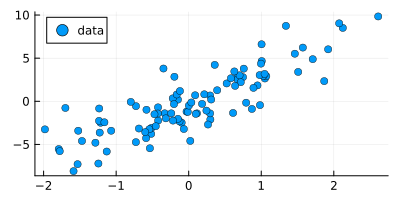

In [11]:
scatter(X, Y, size = (400, 200), label = "data"  )

In [12]:
# Linear regression
out = lm(@formula(Y ~ X), df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Y ~ 1 + X

Coefficients:
────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────
(Intercept)  -0.25643    0.197721  -1.30    0.1977  -0.648801   0.135941
X             3.19593    0.203858  15.68    <1e-27   2.79138    3.60048
────────────────────────────────────────────────────────────────────────

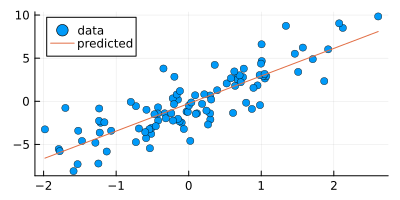

In [13]:
plot!(X, predict(out, select(df, :X)), label = "predicted" )

## What is a macro?

Macros are a way to perform metaprogramming in Julia. They can be a powerful tool for writing code quickly, but it is important to consider whether they are the best option for any given task. The process of a macro consist into first parsing and evaluating the macro, then the code produced by the macro is evaluated like an ordinary expression. Macros can be thought of as the "code of code". Writing a macro for the first time can be a challenging experience, as it requires understanding how it transforms an expression into something else. That is why it is important to consider whether using macros is really necessary or if regular functions could suffice  without introducing additional complexity. It is best to think carefully before deciding if macros are the most suitable option rather than relying solely on their potential power and convenience.    
Before giving an example of macros and demonstrating how to create one, let's first take a look at how expressions are represented and evaluated.

## Expression and Evaluations

There are various methods for constructing an expression. For more information, follow this [link](https://docs.julialang.org/en/v1/manual/metaprogramming/). We can create an expression directly using the prefix `:` or by parsing a string with the function `Meta.parse()`. Let's take a look at a simple example to create and evaluate the expression: `3 + 7`.

In [1]:
# example with the ':' prefix
expr1 = :(3+7) 

:(3 + 7)

In [2]:
typeof(expr1)

Expr

In [3]:
# example
string_expr = "3 + 7"
expr2 = Meta.parse(string_expr)

:(3 + 7)

Julia provides the ability to interpolate literals or expressions into quoted expressions using a prefix `$`. This allows for more dynamic control of strings and other data types when building out code.

In [4]:
a = 3
b = 7
expr3 = :($a + $b)

:(3 + 7)

To evaluate an expression object in Julia, we can use the `eval` function:

In [5]:
eval(expr3)

10

In the case we have multiple expression to evalulate, we can use the quoting method with the `quote [...] end` block:

In [6]:
expr4 = quote
            a = 3
            b = 7
            a + b
end

quote
    #= In[6]:2 =#
    a = 3
    #= In[6]:3 =#
    b = 7
    #= In[6]:4 =#
    a + b
end

In [7]:
eval(expr4)

10

## How to create a macro?

Programming macros require a higher level of coding expertise and knowledge of potential issues that need to be avoided. To ensure the macro is hygienic, it is important to guarantee that the expanded expression does not introduce any variables which conflict with existing ones in the surrounding code. More information about building Julia hygieninc macro can found [here](https://docs.julialang.org/en/v1/manual/metaprogramming/#Hygiene). 
To demonstrate how to create a macro, we will construct a basic one.

In [14]:
using Distributions

In the following example, the function receives a value (i.e., the distribution information), but it does not retain the variable name that was assigned to it by the user. As such, when using this function, any previously assigned variable name is lost.

In [15]:
function show_var_dist(variable)
    println("The distribution of the variable you passed is ", variable)
end;

Let have two random variables, named X₁ and X₂, with two distinct distributions.

In [16]:
X₁ = Normal(0, 1)
X₂ = Cauchy(1, 1)

Cauchy{Float64}(μ=1.0, σ=1.0)

In [17]:
show_var_dist(X₁)
show_var_dist(X₂)

The distribution of the variable you passed is Normal{Float64}(μ=0.0, σ=1.0)
The distribution of the variable you passed is Cauchy{Float64}(μ=1.0, σ=1.0)


We can see that any information about the random variable names used is lost (*i.e.*, X₁ and X₂), as the function only knows that these two distributions, Normal and Cauchy, were passed. If we require the information from variable names, we need to create a macro.

In [18]:
macro show_var_dist(variable)
    quote
        println("The distribution of ",  $(string(variable)), " you passed is ", $(esc(variable)))
    end
end

@show_var_dist(X₁)
@show_var_dist(X₂)

The distribution of X₁ you passed is Normal{Float64}(μ=0.0, σ=1.0)
The distribution of X₂ you passed is Cauchy{Float64}(μ=1.0, σ=1.0)


In [19]:
versioninfo()

Julia Version 1.8.5
Commit 17cfb8e65e (2023-01-08 06:45 UTC)
Platform Info:
  OS: Windows (x86_64-w64-mingw32)
  CPU: 4 × Intel(R) Core(TM) i5-6500 CPU @ 3.20GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-13.0.1 (ORCJIT, skylake)
  Threads: 1 on 4 virtual cores
